[TOC](../toc.ipynb)

Introduction to optimization
============================

- KEYWORDS: scipy.optimize.minimize


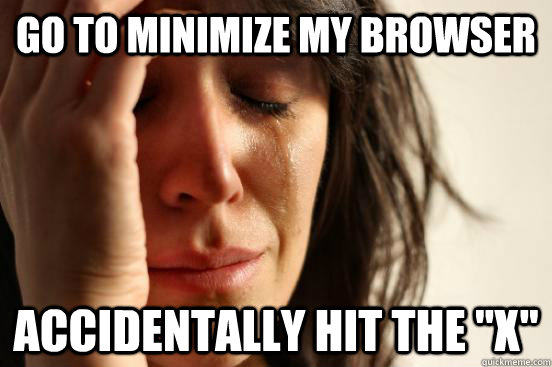

![map](http://kitchingroup.cheme.cmu.edu/f19-06623/06623-roadmap.png)

## Function extrema



It is pretty common to need to find extreme values of a function in engineering analysis. An extreme value is often a maximum or minimum in a function, and we seek them when we want to maximize a profit function, or minimize a cost function, identify a maximum safe operating condition, etc.

Let's consider an example function with a graphical solution approach. We want a quantitative estimate of the minimum in this function.

The function is $f(x) = x^2 + \exp(-5 x^2)$

Think about what this function should look like.


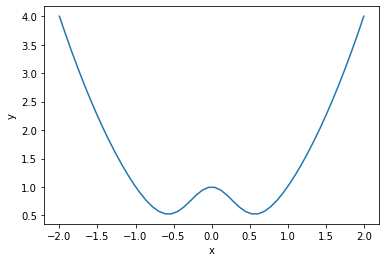

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def f(x):
    return x**2 + np.exp(-5 * x**2)


x = np.linspace(-2, 2)
y = f(x)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y");

You can see there is a minimum near 0.6. We can find the minimum in a crude kind of way by finding the index of the minimum value in the y-array, and then getting the corresponding value of the x-array. You control the accuracy of this answer by the number of points you discretize the function over.

In [2]:
y

array([4.        , 3.68013329, 3.37359438, 3.08038338, 2.80050062,
       2.53394733, 2.28072752, 2.04085335, 1.81435899, 1.60133337,
       1.40198984, 1.21679943, 1.04671548, 0.89349729, 0.76008211,
       0.65085188, 0.57152145, 0.52831859, 0.52624337, 0.56656244,
       0.64424335, 0.74650297, 0.85365611, 0.94276622, 0.99337071,
       0.99337071, 0.94276622, 0.85365611, 0.74650297, 0.64424335,
       0.56656244, 0.52624337, 0.52831859, 0.57152145, 0.65085188,
       0.76008211, 0.89349729, 1.04671548, 1.21679943, 1.40198984,
       1.60133337, 1.81435899, 2.04085335, 2.28072752, 2.53394733,
       2.80050062, 3.08038338, 3.37359438, 3.68013329, 4.        ])

In [3]:
min(y)  # this is the min value in y

0.5262433682550042

In [4]:
np.argmin(y)

18

In [5]:
x[np.argmin(y)], y[np.argmin(y)]

(-0.5306122448979593, 0.5262433682550042)

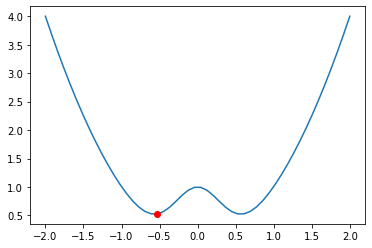

In [6]:
plt.plot(x, y, x[np.argmin(y)], y[np.argmin(y)], "ro");

0.5673711580772052


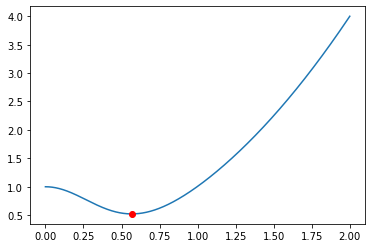

In [7]:
x = np.linspace(0, 2, 15000)
y = f(x)
i = np.argmin(y)  # gives us the index of the minimum in y
print(x[i])  # estimate for the x where y is a min
plt.plot(x, y, x[np.argmin(y)], y[np.argmin(y)], "ro");

What are the pros and cons of this method:

Pros:

1.  It is *easy*.
2.  You *see* the whole domain you are looking at, and it is easy to see how many extrema there are

Cons:

1.  *Lot's* of function evaluations. Imagine if it took a long time to compute each value.
2.  Somewhat tedious.
3.  Not so easy to reproduce
4.  Not scalable to large problems, your time to do this becomes a limiting factor.



### Find the derivative, and solve for where it is zero



We can also derive the first derivative:

$f' = 2 * x + e^{-5 x^2} (-10 * x)$

and solve it for zero using fsolve.



In [8]:
def fp(x):
    return 2 * x + np.exp(-5 * x**2) * (-10 * x)


from scipy.optimize import fsolve

(ans,) = fsolve(fp, 0.5)
ans

0.5673513747994452

In [9]:
d = 0.001
f(0 - d), f(0), f(0 + d)  # this is a maximum at x=0

(0.9999960000125, 1.0, 0.9999960000125)

In [10]:
f(ans - d), f(ans), f(ans + d)  # this is a minimum

(0.5218908017716101, 0.5218875824868201, 0.5218908009437597)

These two answers agree to 5 decimal places.

This depends on your ability to correctly derive and implement the derivative. It is good to know you can solve this problem by more than one method. Here, we use a numerical derivative in the function instead to check our derivative. You can check the convergence of the derivative by varying the dx.



In [11]:
from scipy.misc import derivative


def ypd(x):
    return derivative(f, x, dx=1e-6)


(ans,) = fsolve(ypd, 0)
print(
    f"""at x=0: y'(0) = {ypd(ans)}
      The second derivative is {derivative(f, ans, dx=1e-6, n=2)}
      """
)
# second derivative is negative => maximum

at x=0: y'(0) = 0.0
      The second derivative is -7.9999340485414905
      


In [12]:
(ans,) = fsolve(ypd, 0.5)
print(
    f"""at x={ans}: y'(0) = {ypd(ans)}
      The second derivative is {derivative(f, ans, dx=1e-6, n=2)}
      """
)
# second derivative is positive => minimum

at x=0.5673513747997387: y'(0) = 0.0
      The second derivative is 6.437739230591433
      


These look the same within tolerance. This is not a beautiful solution, but it is hard to argue with success here!



In [13]:
a = [[1, 2, 3], [-1, -2, -3]]
print(np.argmin(a, axis=1))  # index of minimima in each row

[0 2]


In [14]:
print(np.argmin(a, axis=0))  # index of minima in each column

[1 1 1]


### Newton-Raphson method of minima finding



To use the Newton-Raphson method to get the minimum, we use an iterative approach with:

$x_{n+1} = x_n - \frac{y'(x_n)}{y''(x_n)}$.

We have to derive these formulas if you want to use analytical derivatives:

$y' = 2 * x + e^{-5 x^2} (-10 * x)$

$y'' = 2 + e^{-5 x^2} (-10 * x)^2 - 10 e^{-5 x^2}$

Alternatively, we can estimate the derivatives numerically using `scipy.misc.derivative`. This has the downside of numerical instability for dx that is too small, or low accuracy if it is too large, and the need to check if you made a good choice for it. On the plus side, it avoids making mistakes in the derivative derivation and implementation.



In [15]:
from scipy.misc import derivative

x0 = 0.2

for i in range(15):
    yp = derivative(f, x0, dx=1e-2, n=1)  # first derivative
    ypp = derivative(f, x0, dx=1e-2, n=2)  # second derivative
    xnew = x0 - yp / ypp
    fnew = f(xnew)

    if np.abs(yp) <= 1e-6:  # this y' \approx 0
        break
    x0 = xnew

xnew, fnew, yp, i

(0.5673577965146211, 0.5218875826195614, -2.8820223985093207e-09, 5)

This answer also agrees to at least 5 decimal places. This is the gist of what happens in root. 

As we have seen many times, finding minima is such a common task that there are dedicated functions available for doing it. One of the is `scipy.optimize.minimize`. This has a similar signature as `scipy.optimize.root`, you give it a function and an initial guess, and it iteratively searches for a minimum.



## scipy.optimize.minimize



In [16]:
from scipy.optimize import minimize

minimize?

Signature:
minimize(
    fun,
    x0,
    args=(),
    method=None,
    jac=None,
    hess=None,
    hessp=None,
    bounds=None,
    constraints=(),
    tol=None,
    callback=None,
    options=None,
)
Docstring:
Minimization of scalar function of one or more variables.

Parameters
----------
fun : callable
    The objective function to be minimized.

        ``fun(x, *args) -> float``

    where ``x`` is an 1-D array with shape (n,) and ``args``
    is a tuple of the fixed parameters needed to completely
    specify the function.
x0 : ndarray, shape (n,)
    Initial guess. Array of real elements of size (n,),
    where 'n' is the number of independent variables.
args : tuple, optional
    Extra arguments passed to the objective function and its
    derivatives (`fun`, `jac` and `hess` functions).
method : str or callable, optional
    Type of solver.  Should be one of

        - 'Nelder-Mead' :ref:`(see here) <optimize.minimize-neldermead>`
        - 'Powell'      :ref:`(see here) <o

Here is the basic use of minimize. As always, we should plot the answer where feasible to make sure it is the minimum we wanted.

In [17]:
def f(x):
    return x**2 + np.exp(-5 * x**2)


guess = 0.1
sol = minimize(f, guess)
sol

      fun: 0.521887582486822
 hess_inv: array([[0.1556014]])
      jac: array([-1.11758709e-07])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 3
     njev: 7
   status: 0
  success: True
        x: array([0.56735135])

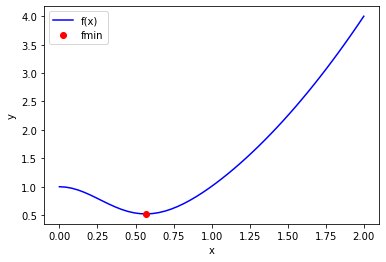

In [18]:
x = np.linspace(0, 2)
y = f(x)

plt.plot(x, y, "b-")
plt.plot(sol.x, sol.fun, "ro")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["f(x)", "fmin"]);

Note this answer is only the same in the first 4 decimal places. Remember that these iterative approaches stop when a tolerance is met. Check the defaults on minimize!



In [19]:
from scipy.optimize import fmin
?fmin
# this is an older method that works fine, but is no longer preferred because minimize does it more flexibly.

Signature:
fmin(
    func,
    x0,
    args=(),
    xtol=0.0001,
    ftol=0.0001,
    maxiter=None,
    maxfun=None,
    full_output=0,
    disp=1,
    retall=0,
    callback=None,
    initial_simplex=None,
)
Docstring:
Minimize a function using the downhill simplex algorithm.

This algorithm only uses function values, not derivatives or second
derivatives.

Parameters
----------
func : callable func(x,*args)
    The objective function to be minimized.
x0 : ndarray
    Initial guess.
args : tuple, optional
    Extra arguments passed to func, i.e., ``f(x,*args)``.
xtol : float, optional
    Absolute error in xopt between iterations that is acceptable for
    convergence.
ftol : number, optional
    Absolute error in func(xopt) between iterations that is acceptable for
    convergence.
maxiter : int, optional
    Maximum number of iterations to perform.
maxfun : number, optional
    Maximum number of function evaluations to make.
full_output : bool, optional
    Set to True if fopt and w

### Multiple minima



It is possible for functions to have more than one minimum. In this case, your guess will determine which minimum is found. Here is an example where there is a minimum near 2.2, and one near 4.5.

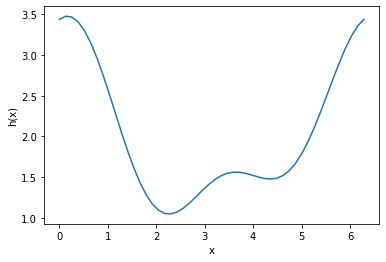

In [20]:
def h(x):
    return 2 + np.cos(x) + np.cos(2 * x - 0.5) / 2


x = np.linspace(0, 2 * np.pi)

plt.plot(x, h(x))
plt.xlabel("x")
plt.ylabel("h(x)");

This guess finds the one near 2.2:



In [21]:
minimize(h, 2)

      fun: 1.0448871783746692
 hess_inv: array([[0.52336562]])
      jac: array([-1.49011612e-08])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([2.26106175])

and this guess finds the one near 4.5



In [22]:
minimize(h, 4)

      fun: 1.4758979742813436
 hess_inv: array([[0.94727357]])
      jac: array([-9.08970833e-07])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([4.355456])

In [23]:
[minimize(h, x).x for x in np.linspace(0, 6, 10)]

[array([-1.92772842]),
 array([2.26106178]),
 array([2.26106266]),
 array([2.26106175]),
 array([2.26106197]),
 array([2.26106154]),
 array([4.355456]),
 array([4.3554493]),
 array([4.35544955]),
 array([2.26106163])]

You have to decide which one is better for the problem at hand. If this were a cost function, the one at the lower cost is probably better! Note that all we can say here is which one is lower in the interval we are looking at. By inspection of the function, you can see it will be periodic, so there will be many other minima that also exist.



### Finding maxima



`minimize` is for finding *minima*. We can use it to find maxima though, by finding the *minima* of $-f(x)$. You can see here that when we plot $-h(x)$ the minima becomes maxima, and vice-versa. Now you can see there are two definite minima, one near zero, and one near 3.5, which correspond to the maxima of $h(x)$.



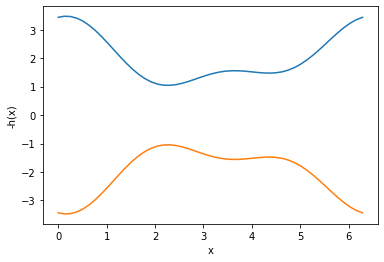

In [24]:
plt.plot(x, h(x), x, -h(x))
plt.xlabel("x")
plt.ylabel("-h(x)");

The standard way to use minimize is to define an optional argument for the sign that defaults to one. Then, when we call minimize, we will pass -1 as the sign to the function, so we find the minimum of -h(x). Then, we evaluate h(x) at that x-value to get the actual value of the maximum. It is not necessary to do this, you can also manually pass around the sign and try to keep it straight.

Here is an example to find the maximum near 3.5.

the maximum is 1.56 at x=3.64


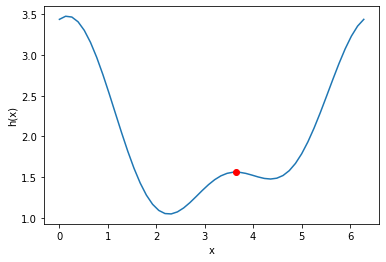

In [25]:
def h(x, sign=1):
    return sign * (2 + np.cos(x) + np.cos(2 * x - 0.5) / 2)


sol = minimize(
    h, 3.5, args=(-1,)
)  # set sign=-1 here to minimize -h(x). Note (-1,) the comma
print(
    f"the maximum is {h(sol.x)[0]:1.2f} at x={sol.x[0]:1.2f}"
)  # sign defaults to 1 here, so we get the maximum value

plt.plot(x, h(x))
plt.plot(sol.x, h(sol.x), "ro")
plt.xlabel("x")
plt.ylabel("h(x)");

In [26]:
def negh(x):
    return -1 * (2 + np.cos(x) + np.cos(2 * x - 0.5) / 2)


sol = minimize(negh, 3.5)
print(f"the maximum is {-1 * negh(sol.x)[0]:1.2f} at x={sol.x[0]:1.2f}")

the maximum is 1.56 at x=3.64


with the optional sign argument, we can find minima and maxima with one function.

the maximum is 1.56 at x=3.64


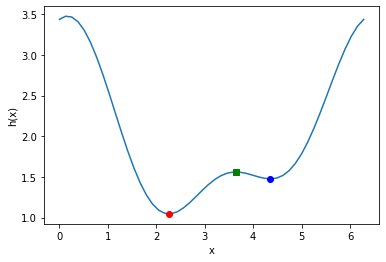

In [27]:
def h(x, sign=1):
    return sign * (2 + np.cos(x) + np.cos(2 * x - 0.5) / 2)


sol1 = minimize(h, 2)  # sign=1 by default so we find a minimum
sol2 = minimize(h, 4)  # sign=1 by default so we find a minimum
sol3 = minimize(h, 3.5, args=(-1,))  # sign=-1, get maxima
print(
    f"the maximum is {h(sol.x)[0]:1.2f} at x={sol.x[0]:1.2f}"
)  # sign defaults to 1 here, so we get the maximum value

plt.plot(x, h(x))
plt.plot(sol1.x, h(sol1.x), "ro")
plt.plot(sol2.x, h(sol2.x), "bo")
plt.plot(sol3.x, h(sol3.x), "gs")
plt.xlabel("x")
plt.ylabel("h(x)");

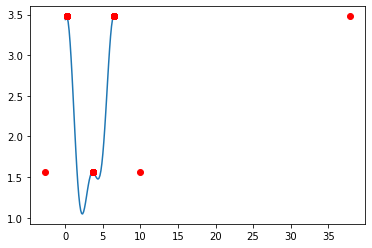

In [28]:
SOL = [minimize(h, g, args=(-1,)) for g in np.linspace(0, 6, 50)]
plt.plot(x, h(x))
plt.plot([sol.x[0] for sol in SOL], [-sol.fun for sol in SOL], "ro");

Once again, here you have to decide which maximum is relevant



### Application to maximizing profit in a PFR



Compound X with concentration of $C_{X0} = 2.5$ kmol / m<sup>3</sup> at a flow rate of 12 m<sup>3</sup>/min is converted to Y in a first order reaction with a rate constant of 30 1/min in a tubular reactor. The value of Y is \\$1.5/kmol. The cost of operation is \\$2.50 per minute per m<sup>3</sup>. Find the reactor length that maximizes the profit (profit is value of products minus operating costs).

First, consider why there is a maximum. At low volumes the operating cost is low, and the production of Y is low. At high volumes, you maximize production of Y, so you have the most value, but the operating costs go up (to infinity for complete conversion!). Somewhere in the middle is where a maximum is.

Here are some relevant constants.



In [29]:
cost = 2.5  # dollar/min/m**3
y_value = 1.5  # dollar / kmol

Cx0 = 2.5  # kmol / m**3
v0 = 12.0  # m**3 / min

k = 30.0  # 1/min

To compute the profit as a function of reactor volume, we need to compute how much Y is produced, then multiply that by the value of Y and subtract the operating cost. To compute how much Y is produced, we use a mole balance on X and Y, and integrate it to the volume to get the molar flows of X and Y. I like to write mole balances like this.



In [30]:
def dFdV(V, F):
    "PFR mole balances on X and Y."
    Fx, Fy = F
    Cx = Fx / v0
    rx = -k * Cx
    ry = -rx

    dFdX = rx
    dFdY = ry
    return [dFdX, dFdY]


# initial conditions
F0 = [Cx0 * v0, 0.0]  # Fx0  # Fy0

Now, we can write a profit function. It will take a V as the argument, integrate the PFR to that volume to find the molar exit flow rates, and then compute the profit.



In [31]:
import numpy as np
from scipy.integrate import solve_ivp


def profit(V, sign=1):
    Vspan = (0, V)
    sol = solve_ivp(dFdV, Vspan, F0)
    Fx, Fy = sol.y
    Fy_exit = Fy[-1]
    return sign * (Fy_exit * y_value - cost * V)

In [32]:
profit(10)

19.999999935332582

It is always a good idea to plot the profit function. We use a list comprehension here because the profit function is not *vectorized*, which means we cannot pass an array of volumes in and get an array of profits out.



In [35]:
# alternative 1 to list comprehension - accumulate by appending to a list
Vspan = np.linspace(0, 10, 5)

PA = []
for V in Vspan:
    PA += [profit(V)]  # append a list to the list
PA

[0.0,
 38.66280377306441,
 32.49983056415947,
 26.249999599753814,
 19.999999935332582]

In [36]:
# alternative 2 to list comprehension - use indexing to set values in an array
PA2 = np.zeros(Vspan.shape)
for i, V in enumerate(Vspan):
    PA2[i] = profit(V)  # brackets in this line are for indexing

PA2

array([ 0.        , 38.66280377, 32.49983056, 26.2499996 , 19.99999994])

(10.0, 38.66280377306441)

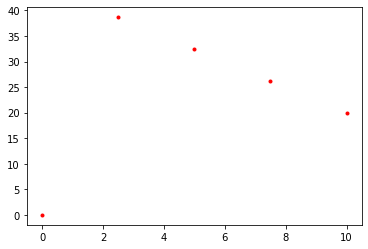

In [37]:
# plot each point, one at a time
maxP = 0.0
maxV = 0
for V in Vspan:
    plt.plot(V, profit(V), "r.")
    if profit(V) > maxP:
        maxP = profit(V)
        maxV = V
V, maxP

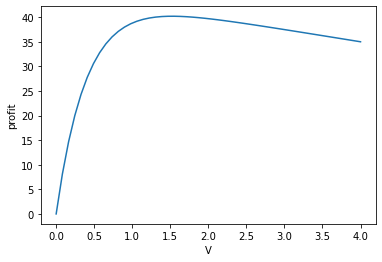

In [38]:
Vspan = np.linspace(0, 4)
profit_array = [profit(V) for V in Vspan]  # these brackets are list comprehension

import matplotlib.pyplot as plt

plt.plot(Vspan, profit_array)
plt.xlabel("V")
plt.ylabel("profit");

In [39]:
Vspan[np.argmax(profit_array)]  # approximate V where the maximum is

1.5510204081632653

You can see from this plot there is a maximum near V=1.5. We can use that as a guess for minimize.



In [40]:
from scipy.optimize import minimize

sol = minimize(
    profit, 1.5, args=(-1,)
)  # minimize -profit, which is equivalent to maximizing it

print(
    f"The optimal volume is {sol.x[0]:1.2f} m^3 with a profit of ${profit(sol.x[0]):1.2f}/min."
)

The optimal volume is 1.52 m^3 with a profit of $40.19/min.


This problem highlights the opportunities we have to integrate many ideas together to solve complex problems. We have integration of an ODE, nonlinear algebra/minimization, with graphical estimates of the solution.

**Challenge** Can you solve this with an event and solve\_ivp?



## Summary



Today we introduced the concept of finding minima/maxima in functions. This is an iterative process, much like finding the roots of a nonlinear function. You can think of it as finding the zeros of the derivative of a nonlinear function! This method is the root of many important optimization problems including regression.

`scipy.optimize.minimize` is the preferred function for doing minimization. There are other more specific ones described at [https://docs.scipy.org/doc/scipy/reference/optimize.html](https://docs.scipy.org/doc/scipy/reference/optimize.html), but `minimize` has a more consistent interface and provides almost all the functionality of those other methods.

Next time, we will look at how to apply minimization to regression problems.

